### 5.6.3动量算法

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline

meshgrid = torch.meshgrid
arange = torch.arange

In [2]:
class SGD:

    """随机梯度下降法（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


In [3]:
class Momentum:

    """Momentum SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            #对v形状与对应参数一致，全置为0
            for key, val in params.items():                                
                self.v[key] = torch.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

### 5.6.4 Nesterov动量算法

In [6]:
class Nestrov:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = torch.zeros_like(val)

        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


### 5.6.5 AdaGrad算法

In [4]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = torch.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


### 5.6.6 RMSProp算法

In [5]:
class RMSprop:
    def __init__(self, lr=0.01, decay_rate=0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = torch.zeros_like(val)

        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key]**2            
            params[key] -=self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


### 5.6.7 Adam算法

In [7]:
class Adam:

    """Adam算法"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = torch.zeros_like(val)
                self.v[key] = torch.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)


### 5.6.8 Yogi算法

In [16]:
class yogi:

    """yogi算法"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = torch.zeros_like(val)
                self.v[key] = torch.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * torch.sign(grads[key]**2 - self.v[key])*grads[key]**2
            #sqr[:] = sqr + (1 - beta2) * torch.sign(torch.square(param.grad) - sqr) * torch.square(param.grad)
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)


### 定义函数及对应导数

In [17]:
def f(x, y):
    return 0.05*x**2  + y**2


def df(x, y):
    return 0.1*x, 2*y

init_pos = torch.tensor([-8.0, 2.0])
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.08)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["RMSprop"]=RMSprop(lr=0.5)
optimizers["Nestrov"]=Nestrov(lr=0.08)
optimizers["Adam"] = Adam(lr=0.4)
optimizers["yogi"] = yogi(lr=0.4)

### 可视化函数等高线及梯度迭代过程

In [9]:
def show_train(key):    
    optimizer = optimizers[key]
    x_history = torch.tensor([])
    y_history = torch.tensor([])
    init_pos = torch.tensor([-9.0, 2.0])
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history=torch.cat([x_history, torch.unsqueeze(params['x'],0)])
        y_history=torch.cat([y_history, torch.unsqueeze(params['y'],0)])
        #y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    
    
    x = arange(-10, 10, 0.1)
    y = arange(-10, 10, 0.1)
    
    #将X和Y放到两个数组，进行笛卡尔乘积
    X, Y = meshgrid(x, y) 
    Z = f(X, Y)
    
    #为生成简单的等高线  
    mask = Z > 20
    Z[mask] = 0
    
    # plot 
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.plot(x_history, y_history, 'o-', color="orange",label=key)
    plt.contour(X, Y, Z,colors='b')
   
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    plt.legend(loc='best')
    plt.title(key+"算法")
    #plt.xlabel("X轴")
    #plt.ylabel("Y轴")
    
    plt.show()

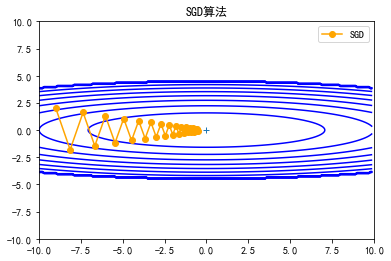

In [10]:
show_train("SGD")

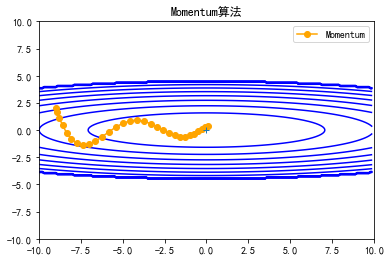

In [11]:
show_train("Momentum")

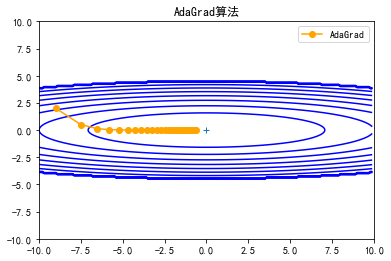

In [12]:
show_train("AdaGrad")

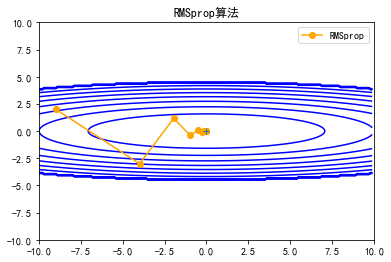

In [13]:
show_train("RMSprop")

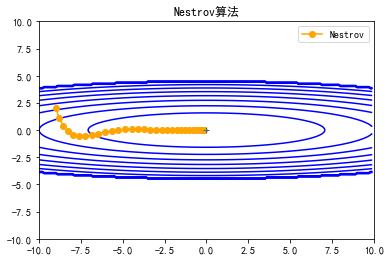

In [14]:
show_train("Nestrov")

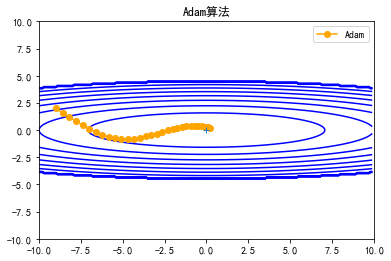

In [15]:
show_train("Adam")

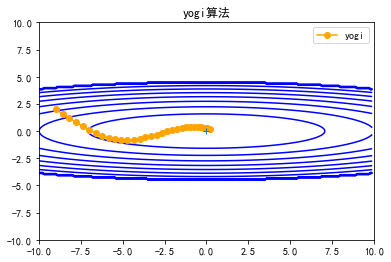

In [18]:
show_train("yogi")